In [24]:
import pandas as pd

df = pd.read_csv("/kaggle/input/patents/patent_corpus.csv")

In [25]:
df.shape

(67068, 3)

In [4]:
import torch
print("PyTorch GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch GPU Available: True
GPU Name: Tesla T4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67068 entries, 0 to 67067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   publication_number  67068 non-null  object
 1   abstract            67068 non-null  object
 2   label               67068 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [26]:
# subset df for only text and label
df = df[['abstract', 'label']]

In [27]:
import numpy as np
SEED = 42

# Always add a stable row_id column *once*
df["row_id"] = np.arange(len(df))

# ------------------------------------------------------------
# 1)  Build the balanced 32-shot TRAIN set
# ------------------------------------------------------------
labels        = sorted(df["label"].unique())
n_labels      = len(labels)          # 9
base          = 32 // n_labels       # → 3
remainder     = 32 - base * n_labels # → 5 extra shots

np.random.seed(SEED)
extra_labels  = np.random.choice(labels, size=remainder, replace=False)

def sample_k(grp):
    k = base + (1 if grp.name in extra_labels else 0)
    return grp.sample(k, random_state=SEED)

train_df = (
    df.groupby("label", group_keys=False)
      .apply(sample_k)
      .reset_index(drop=True)
)

print("TRAIN label counts\n", train_df["label"].value_counts())

TRAIN label counts
 label
a    4
b    4
y    4
h    4
f    4
e    3
d    3
c    3
g    3
Name: count, dtype: int64


/tmp/ipykernel_35/1767580291.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sample_k)


In [28]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, Features, Value, ClassLabel

# ------------------------------------------------------------
# 2)  Everything else → TEMP pool
# ------------------------------------------------------------
temp_df = df.loc[~df["row_id"].isin(train_df["row_id"])].reset_index(drop=True)

# When you make eval_df and test_holdout_df
eval_df, test_holdout_df = train_test_split(
    temp_df,
    test_size=0.90,
    stratify=temp_df["label"],
    random_state=SEED
)
eval_df         = eval_df.reset_index(drop=True)        # <—
test_holdout_df = test_holdout_df.reset_index(drop=True)


# ------------------------------------------------------------
# 4)
# ------------------------------------------------------------
# treat test_holdout_df as “unlabeled” by removing the ground-truth labels
pseudo_pool_df = (
    test_holdout_df
      .drop(columns=["label"])     # <-- removes the gold labels
      .reset_index(drop=True)      # keep a clean index
)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [29]:
# ------------------------------------------------------------
# 5)  Convert each to HF Dataset  (future-proof & RAM-safe)
# ------------------------------------------------------------
feature_spec = Features({
    "text" : Value("string"),
    "label": ClassLabel(names=labels),
    "row_id": Value("int64")
})

# Create a feature spec for the pseudo_pool_ds which does not have a 'label' column
pseudo_pool_feature_spec = Features({
    "text" : Value("string"),
    "row_id": Value("int64")
})

train_ds        = Dataset.from_pandas(train_df.rename(columns={"abstract":"text"}),        features=feature_spec)
eval_ds         = Dataset.from_pandas(eval_df.rename(columns={"abstract":"text"}),         features=feature_spec)
test_holdout_ds = Dataset.from_pandas(test_holdout_df.rename(columns={"abstract":"text"}), features=feature_spec)
# Use the pseudo_pool_feature_spec for the pseudo_pool_df
pseudo_pool_ds  = Dataset.from_pandas(pseudo_pool_df.rename(columns={"abstract":"text"}),  features=pseudo_pool_feature_spec)

print("HF splits ready:",
      len(train_ds), len(eval_ds), len(test_holdout_ds), len(pseudo_pool_ds))

HF splits ready: 32 6703 60333 60333


In [19]:
# 0) If you haven’t installed transformers yet, uncomment and run:
# !pip install transformers

import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# 1) Load your DataFrame (assumes df exists with an "abstract" column)
#    Replace the model name below if you want to use a different tokenizer
tokenizer = AutoTokenizer.from_pretrained("AI-Growth-Lab/PatentSBERTa")

# 2) Compute token counts (including special tokens)
token_lengths = df["abstract"].apply(
    lambda txt: len(tokenizer.encode(txt, add_special_tokens=True))
)

# 3) Print summary statistics
print("Summary of abstract token lengths:")
print(token_lengths.describe(), "\n")

# 4) Show the 10 most common lengths
print("Top 10 most common token lengths:")
print(token_lengths.value_counts().head(10), "\n")

# 5) Plot a histogram
plt.figure(figsize=(8, 4))
token_lengths.hist(bins=30)
plt.xlabel("Abstract length (tokens)")
plt.ylabel("Count")
plt.title("Distribution of Abstract Lengths (in tokens)")
plt.show()

KeyboardInterrupt: 

In [30]:
!pip -q install "torch>=2.1" transformers datasets setfit accelerate evaluate sentinel sentencepiece

In [32]:
##############################################################
# 0) Imports, reproducibility, device
##############################################################
import pandas as pd
import numpy as np
import random
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, Features, Value, ClassLabel
from setfit import SetFitModel, Trainer        # SetFit ≥ 0.8
import evaluate
import logging

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)



In [15]:
!pip install SetFit

## Few Shot Learning with SetFit

### Using MiniLM sentence embeddings

In [135]:
##############################################################
# 4) Load a smaller/faster encoder: MiniLM
##############################################################
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2' #"AI-Growth-Lab/PatentSBERTa"
head_params = {
    # ----- capacity & regularisation -----
    "C": 5,                     # moderate L2; 0.25–1.0 is the sweet spot
    "penalty": "l2",              # L2 regularisation
    # ----- multiclass setting ------------
    "multi_class": "multinomial", # joint soft-max over the 9 sections
    "class_weight": "balanced",   # handles A/C dominance
    # ----- optimiser ---------------------
    "solver": "lbfgs",            # good for small dense data
    "max_iter": 1000,             # plenty of room to converge
    "n_jobs": -1                  # use all CPU cores
}
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS, head_params=head_params)
model.to(DEVICE)
,

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


''

Define training arguments. We are limited to batchsize = 8 due to RAM limitations. We also cannot evaluate during training as that would require loading eval into RAM.

In [138]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=64,
    num_epochs=(40,4),

    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [140]:
# 4) Initialize the trainer
from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    #eval_dataset=eval_ds
)
# 5) Train!
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 908
  Batch size = 64
  Num epochs = 40


Step,Training Loss
1,0.156100
50,0.110000
100,0.021800
150,0.005000
200,0.002500
250,0.001800
300,0.001500


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [141]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.39      0.42      0.40       967
           b       0.24      0.17      0.20       897
           c       0.58      0.40      0.47       561
           d       0.08      0.39      0.13        56
           e       0.10      0.22      0.14       191
           f       0.18      0.57      0.27       475
           g       0.54      0.24      0.33      1438
           h       0.47      0.33      0.39      1427
           y       0.10      0.11      0.11       691

    accuracy                           0.30      6703
   macro avg       0.30      0.32      0.27      6703
weighted avg       0.38      0.30      0.31      6703



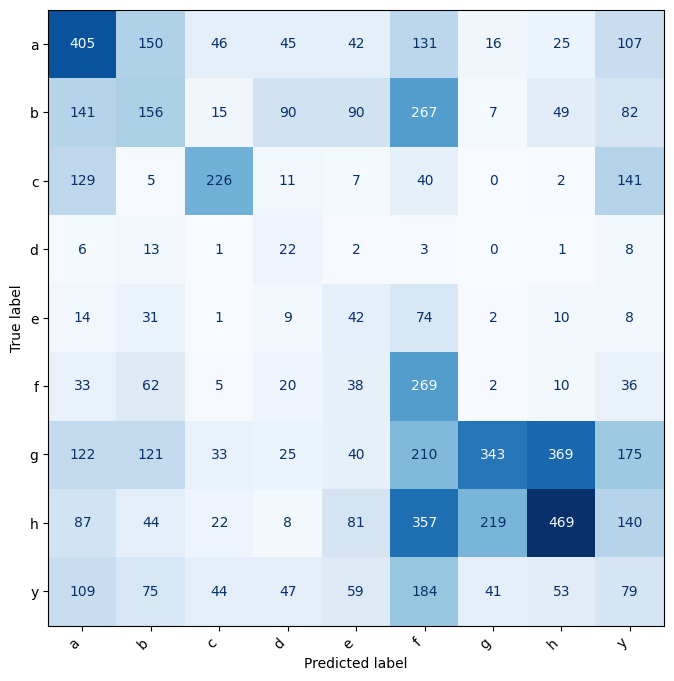

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

### Differentiable classification head

In [ ]:
from setfit import SetFitModel, SetFitTrainer, TrainingArguments
import datasets

# ----------------   1)  Model with differentiable head   ----------------
BASE_ENCODER = 'all-MiniLM-L6-v2'

model = SetFitModel.from_pretrained(
    BASE_ENCODER,
    labels=LABELS,
    head_params={"out_features": 9},
    use_differentiable_head=True,
    multi_target_strategy=None          # single-label
)

# ----------------   2)  TrainingArguments (no eval)     ----------------
args = TrainingArguments(
    batch_size=(32, 16),
    num_epochs=(8, 8),
    end_to_end=True,
    body_learning_rate=(2e-5, 5e-6),
    head_learning_rate=2e-5,
    l2_weight=0.02,
)

# ----------------   3)  Trainer (train_ds only)         ----------------
trainer = Trainer(
    model         = model,
    train_dataset = train_ds,   # 32 balanced rows
    eval_dataset  = None,       # <-- no dev split
    args          = args,
)

trainer.train()                 # runs 3 full epochs, prints only train loss

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 908
  Batch size = 32
  Num epochs = 8


Step,Training Loss
1,0.199200
50,0.122200


In [190]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.22      0.46      0.30       967
           b       0.18      0.24      0.21       897
           c       0.35      0.44      0.39       561
           d       0.04      0.55      0.07        56
           e       0.01      0.02      0.01       191
           f       0.08      0.05      0.07       475
           g       0.40      0.13      0.20      1438
           h       0.17      0.10      0.13      1427
           y       0.03      0.00      0.00       691

    accuracy                           0.19      6703
   macro avg       0.16      0.22      0.15      6703
weighted avg       0.22      0.19      0.18      6703



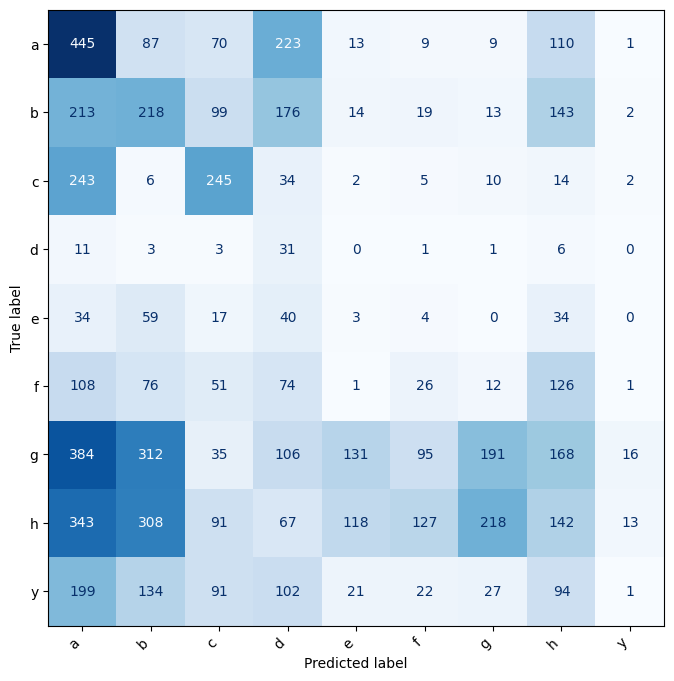

In [191]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

### SetFit with Patent SBERta

Now we are going to train a SetFit model with 32 labeled abstracts. As the embedding model we chose PatentSBERTa by

In [72]:
##############################################################
# 4) Load a smaller/faster encoder: PatentSBERTa-base
##############################################################
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = "AI-Growth-Lab/PatentSBERTa"
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [73]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=16,
    num_epochs=(6,2),

    eval_strategy="no"
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [37]:
import os, psutil

proc = psutil.Process(os.getpid())
mem = proc.memory_info().rss / (1024**3)
print(f"Python is using {mem:.2f} GB RAM")

Python is using 2.45 GB RAM


Due to RAM limitations we cannot evaluate during training.

In [74]:
# 4) Initialize the trainer
from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 908
  Batch size = 16
  Num epochs = 6


Step,Training Loss
1,0.179400
50,0.110200
100,0.018600
150,0.006900


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)


Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.24      0.34      0.28       967
           b       0.25      0.24      0.25       897
           c       0.41      0.32      0.36       561
           d       0.08      0.20      0.11        56
           e       0.09      0.17      0.12       191
           f       0.22      0.40      0.29       475
           g       0.53      0.26      0.35      1438
           h       0.50      0.37      0.43      1427
           y       0.11      0.14      0.13       691

    accuracy                           0.29      6703
   macro avg       0.27      0.27      0.26      6703
weighted avg       0.35      0.29      0.31      6703



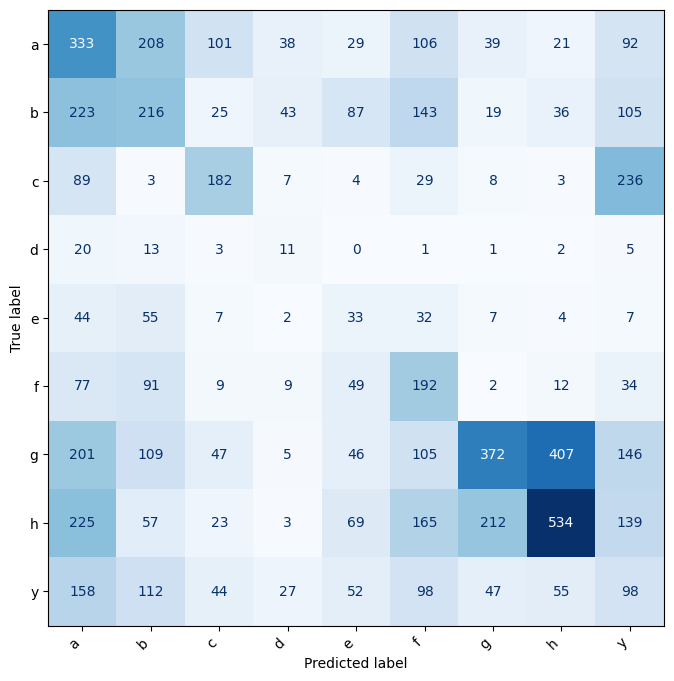

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

## Creating more data



Now we are going to use the SetFit model trained earlier to predict the labels of some unlabeled abstracts. We then keep those predictions whose class-probability is very high (e.g., ≥ 90 %) and add these as "pseudo-labled" data to our original training set.


In [143]:
SUBFRAC   = 1             # 10 %
sub_size  = int(len(pseudo_pool_ds) * SUBFRAC)

# 1) take a reproducible 10 % subsample
sub_pseudo_ds = (
    pseudo_pool_ds
    .shuffle(seed=SEED)         # randomise order once
    .select(range(sub_size))    # first N rows = 10 %
)

print("subsample size:", len(sub_pseudo_ds))   # sanity-check

subsample size: 60333


In [144]:
texts = sub_pseudo_ds["text"]
probs = model.predict_proba(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/943 [00:00<?, ?it/s]

This step turns each raw probability vector into a single “confidence” score (the highest class probability) and its corresponding predicted label, then discards any examples where the model is less than 90 % sure.

In [146]:
# 1) Attach your probs back onto the Dataset
#    (probs is an [N,9] NumPy array, texts = sub_pseudo_ds["text"])
scored_ds = sub_pseudo_ds.add_column(
    "probs",
    [row.tolist() for row in probs]   # one list[float] per example
)

import numpy as np

def add_conf_pred(batch):
    p = np.array(batch["probs"])
    batch["confidence"] = p.max(axis=1).tolist()
    batch["pred_label"] = p.argmax(axis=1).tolist()
    return batch

scored_ds = scored_ds.map(add_conf_pred, batched=True)

THRESH = 0.7
pseudo_ds = scored_ds.filter(lambda ex: ex["confidence"] >= THRESH)
print("High-confidence rows:", len(pseudo_ds))

Flattening the indices:   0%|          | 0/60333 [00:00<?, ? examples/s]

Map:   0%|          | 0/60333 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60333 [00:00<?, ? examples/s]

High-confidence rows: 547


In [147]:
import pandas as pd

# 1) Pull out the predicted label IDs
pred_ids = pseudo_ds["pred_label"]

# 2) Turn into a Pandas Series and count
dist = pd.Series(pred_ids).value_counts().sort_index()

# 3) (Optional) map back to your human-readable label names
label_names = train_ds.features["label"].names
dist.index = [label_names[i] for i in dist.index]

print("High-confidence pseudo-label distribution:")
print(dist)

High-confidence pseudo-label distribution:
a     47
b      7
c     30
d      1
e     14
f    254
g     61
h    124
y      9
Name: count, dtype: int64


a bit unbalanced as expected. Due to time limitations let´s pick 10 for

In [148]:
import pandas as pd
import numpy as np
from datasets import Dataset, concatenate_datasets
from collections import Counter

# 1) Convert pseudo_ds to a Pandas DataFrame
pseudo_df = pseudo_ds.to_pandas()

# 2) For each predicted label, pick the 10 rows with highest confidence
top10_df = (
    pseudo_df
    .groupby('pred_label', group_keys=False)
    .apply(lambda grp: grp.nlargest(10, 'confidence'))
    .reset_index(drop=True)
)

top10_df_clean = top10_df[["text", "pred_label"]].rename(columns={"pred_label":"label"})

/tmp/ipykernel_35/3253376384.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.nlargest(10, 'confidence'))


In [149]:
start_id = max(train_ds["row_id"]) + 1
top10_df_clean["row_id"] = np.arange(start_id, start_id + len(top10_df_clean))

top10_ds = Dataset.from_dict(
    {
        "text":  top10_df_clean["text"].tolist(),
        "label": top10_df_clean["label"].tolist(),
        "row_id": top10_df_clean["row_id"].tolist()
    }
).cast(train_ds.features)        # make label → ClassLabel

Casting the dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

In [150]:
big_train_ds = concatenate_datasets([train_ds, top10_ds])  # 32 + 90 = 122 rows

Lets train with the new data

In [153]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=64,
    num_epochs=(6,None),

    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [151]:
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2' #"AI-Growth-Lab/PatentSBERTa"
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [154]:

from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=big_train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/109 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 10480
  Batch size = 64
  Num epochs = 6


Step,Training Loss
1,0.187500
50,0.140800
100,0.036800
150,0.007600
200,0.003600
250,0.002200
300,0.001500
350,0.001300
400,0.001200
450,0.001000


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [155]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.40      0.48      0.44       967
           b       0.25      0.15      0.18       897
           c       0.56      0.28      0.38       561
           d       0.14      0.12      0.13        56
           e       0.11      0.31      0.16       191
           f       0.19      0.57      0.28       475
           g       0.54      0.29      0.37      1438
           h       0.49      0.34      0.40      1427
           y       0.13      0.17      0.15       691

    accuracy                           0.31      6703
   macro avg       0.31      0.30      0.28      6703
weighted avg       0.39      0.31      0.33      6703



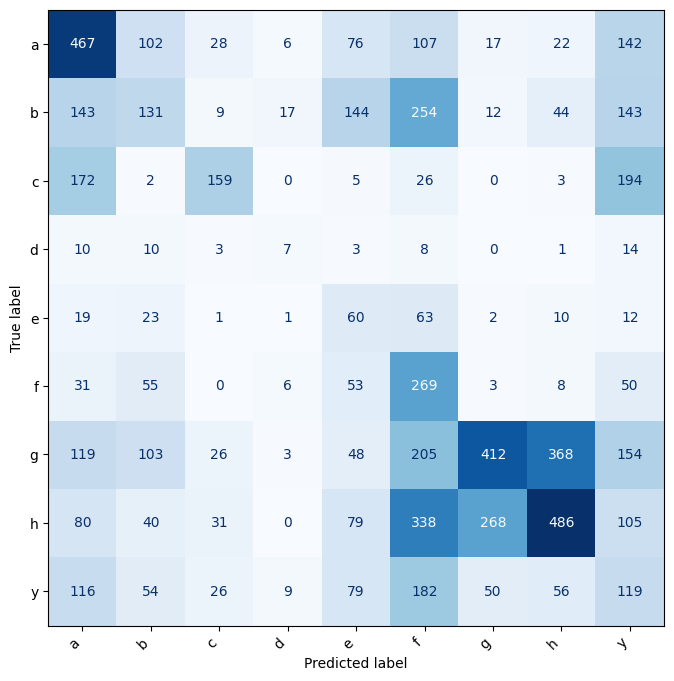

In [156]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

### Zero Shot with LLM

Here we are going to use an LLM to classify the patent abstracts. We are using Mistral`s LLM mistral-small-latest which is available through their api as part of the free tier.

The prompts passed to the LLM look something like this:  

system message:

You are an expert patent-classification assistant.  
Choose **exactly one** of the following IPC section letters for every abstract you receive  
and return only that single letter—nothing else.

A: Human necessities  
B: Performing operations; transporting  
C: Chemistry; metallurgy  
D: Textiles; paper  
E: Fixed constructions  
F: Mechanical engineering; lighting; heating; weapons; blasting  
G: Physics  
H: Electricity  
Y: Emerging cross-sectional technologies

user message:
Patent abstract:
A portable device includes a rechargeable electro-chemical cell coupled to
a power-management circuit that wirelessly transmits energy to external loads
via an inductive coil.  The circuit actively regulates output current to
optimize efficiency while protecting the cell from over-discharge.

Section letter:

In [43]:
#!pip install -qU litellm tqdm
import os

# ── 1.  API key & model -------------------------------------------------
os.environ["MISTRAL_API_KEY"] = "1jwUcSzw7IwGdusNjHmnmKfMuWpf4qg3"        #  ← paste your key here
MODEL = "mistral/mistral-small-latest"

Careful! This takes around 3 hours to run as we are limited to 1 request per second with mistral free tier.

In [ ]:
# ================================================================
# Zero-shot IPC classification on eval_ds with Mistral via LiteLLM
# ================================================================


import os, re, json, time
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from litellm import completion

   # provider prefix in model string

# ── 2.  IPC label list & prompt pieces ---------------------------------
label_names = train_ds.features["label"].names  # ["a","b",...,"y"]
IPC_DESCR = {
    "A": "Human necessities",
    "B": "Operations / transporting",
    "C": "Chemistry / metallurgy",
    "D": "Textiles / paper",
    "E": "Fixed constructions",
    "F": "Mechanical engineering, lighting, heating, weapons, blasting",
    "G": "Physics",
    "H": "Electricity",
    "Y": "Emerging cross-section technologies"
}
SYSTEM_MSG = (
    "You are an expert patent classifier.\n"
    "Choose **exactly one** IPC section letter for each abstract:\n" +
    "\n".join(f"{k}: {v}" for k,v in IPC_DESCR.items()) +
    "\nReturn only the single letter (A-H or Y)."
)
name2id = {n.upper(): i for i, n in enumerate(label_names)}


# ── 3.  Helper to query Mistral once -----------------------------------
def predict_label(abstract, temp=0):
    prompt = f"Patent abstract:\n{abstract}\n\nSection letter:"
    resp = completion(
        model=MODEL,
        api_key=os.getenv("MISTRAL_API_KEY"),
        messages=[{"role":"system","content":SYSTEM_MSG},
                  {"role":"user"  ,"content":prompt}],
        temperature=temp
    )
    raw = resp.choices[0].message.content.strip()
    m   = re.search(r"\b([A-HY])\b", raw, re.I)
    return m.group(1).upper() if m else "UNK"

# ── 4.  Loop over eval_ds ----------------------------------------------
texts = eval_ds["text"]
true  = np.array(eval_ds["label"])
pred  = []

for t in tqdm(texts, desc="LLM zero-shot"):
    lbl = predict_label(t)
    pred.append(name2id.get(lbl, -1))   # -1 for unknown/unmapped
    time.sleep(1.0)                     # free-tier ≈ 60 req/min

pred = np.array(pred)
mask = pred != -1                       # keep rows with a valid label



LLM zero-shot:   0%|          | 0/6703 [00:00<?, ?it/s]

In [44]:
# ================================================================
# Zero-shot IPC classification on eval_ds with Mistral (JSON mode)
# ================================================================

import os, json, time
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import classification_report, f1_score
from litellm import completion
                # provider prefix if needed

# ── 1. label mapping ----------------------------------------------------
label_names = train_ds.features["label"].names   # ["a","b",...,"y"]
name2id     = {n.upper(): i for i, n in enumerate(label_names)}

IPC_DESCR = {
    "A": "Human necessities",
    "B": "Operations / transporting",
    "C": "Chemistry / metallurgy",
    "D": "Textiles / paper",
    "E": "Fixed constructions",
    "F": "Mechanical engineering; lighting; heating; weapons; blasting",
    "G": "Physics",
    "H": "Electricity",
    "Y": "Emerging cross-section technologies"
}

SYSTEM_MSG = (
    "You are an expert patent classifier.\n"
    "For each user message return **JSON** *exactly* of the form:\n"
    '{"section": "<LETTER>"}\n'
    "where <LETTER> is one of A-H or Y.\n"
    "Descriptions:\n" +
    "\n".join(f"{k}: {v}" for k, v in IPC_DESCR.items())
)

# ── 2. helper -----------------------------------------------------------
def predict_label(abstract, temp=0.3):
    prompt = f"Patent abstract:\n{abstract[:800]}\n\nReturn JSON now."
    resp = completion(
        model           = MODEL,
        api_key         = os.getenv("MISTRAL_API_KEY"),
        messages        = [
            {"role": "system", "content": SYSTEM_MSG},
            {"role": "user",   "content": prompt}
        ],
        response_format = {"type": "json_object"},   # ← JSON mode
        temperature     = temp,
        max_tokens      = 20,
    )
    try:
        section = json.loads(resp.choices[0].message.content)["section"].upper()
        return section if section in IPC_DESCR else "UNK"
    except Exception:
        return "UNK"

# ── 3. classify ---------------------------------------------------------
texts = eval_ds["text"]
true  = np.array(eval_ds["label"])
pred  = []

for t in tqdm(texts, desc="LLM zero-shot"):
    section = predict_label(t)
    pred.append(name2id.get(section, -1))
    time.sleep(1.0)          # stay under ~60 req/min on free tier

pred = np.array(pred)
valid = pred != -1

unk_rate = 1 - valid.mean()
print(f"UNK rate: {unk_rate:.2%}")

macro_f1 = f1_score(true[valid], pred[valid], average="macro") if valid.any() else 0.0
print("Macro-F1:", macro_f1)
print(classification_report(true[valid], pred[valid], target_names=label_names))

LLM zero-shot:   0%|          | 0/6703 [00:00<?, ?it/s]23:14:37 - LiteLLM:INFO: utils.py:3101 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
2025-06-14 23:14:37,045 | INFO | 
LiteLLM completion() model= mistral-small-latest; provider = mistral
2025-06-14 23:14:37,541 | INFO | HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"
23:14:37 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
2025-06-14 23:14:37,549 | INFO | Wrapper: Completed Call, calling success_handler
23:14:37 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
2025-06-14 23:14:37,552 | INFO | selected model name for cost calculation: mistral/mistral-small-latest
LLM zero-shot:   0%|          | 1/6703 [00:01<2:49:17,  1.52s/it]23:14:38 - LiteLLM:INFO: utils.py:3101 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
2025-06-14 23:14:38,556 | INFO | 
LiteLLM com

KeyboardInterrupt: 

In [45]:
# --- choose just 10 items ------------------------------------------------
sample_ds = eval_ds.select(range(10))      # or .shuffle(seed=42).select(...)
texts = sample_ds["text"]
true  = np.array(sample_ds["label"])

pred = []
for t in tqdm(texts, desc="LLM zero-shot (10 ex)"):
    section = predict_label(t)             # ← the JSON-mode helper
    pred.append(name2id.get(section, -1))
    time.sleep(1.0)                        # keep the free-tier rate-limit

pred   = np.array(pred)
valid  = pred != -1                        # rows where we got a legal letter
unk_rt = 1 - valid.mean()
print(f"UNK rate: {unk_rt:.2%}")

if valid.any():                            # avoid zero-division if all UNK
    macro_f1 = f1_score(true[valid], pred[valid], average="macro")
    print("Macro-F1 (10 ex):", macro_f1)
    print(classification_report(true[valid], pred[valid],
                                target_names=label_names))
else:
    print("Every response was UNK – no valid predictions in the sample.")

LLM zero-shot (10 ex):   0%|          | 0/10 [00:00<?, ?it/s]23:16:06 - LiteLLM:INFO: utils.py:3101 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
2025-06-14 23:16:06,137 | INFO | 
LiteLLM completion() model= mistral-small-latest; provider = mistral
2025-06-14 23:16:06,596 | INFO | HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"
23:16:06 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
2025-06-14 23:16:06,600 | INFO | Wrapper: Completed Call, calling success_handler
23:16:06 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
2025-06-14 23:16:06,602 | INFO | selected model name for cost calculation: mistral/mistral-small-latest
LLM zero-shot (10 ex):  10%|█         | 1/10 [00:01<00:13,  1.48s/it]23:16:07 - LiteLLM:INFO: utils.py:3101 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
2025-06-14 23:16:07,615 | INFO | 
L

UNK rate: 0.00%
Macro-F1 (10 ex): 0.5833333333333333


ValueError: Number of classes, 4, does not match size of target_names, 9. Try specifying the labels parameter


Zero-shot macro-F1 on eval_ds: 0.303
Coverage (valid predictions):   100.0%

Detailed break-down:
              precision    recall  f1-score   support

           a       0.74      0.27      0.39       967
           b       0.39      0.01      0.03       897
           c       0.46      0.84      0.60       561
           d       0.16      0.45      0.24        56
           e       0.43      0.21      0.29       191
           f       0.18      0.83      0.29       475
           g       0.48      0.23      0.31      1438
           h       0.48      0.71      0.57      1427
           y       0.15      0.00      0.01       691

    accuracy                           0.38      6703
   macro avg       0.39      0.40      0.30      6703
weighted avg       0.44      0.38      0.33      6703



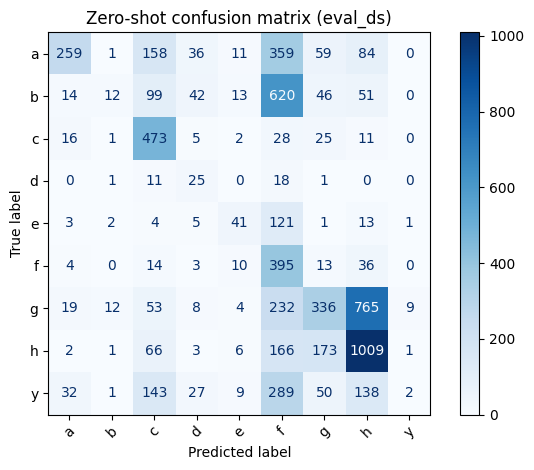

In [19]:
# ── 5.  Metrics ---------------------------------------------------------
macro_f1 = f1_score(true[mask], pred[mask], average="macro")
print(f"\nZero-shot macro-F1 on eval_ds: {macro_f1:.3f}")
print(f"Coverage (valid predictions):   {mask.mean()*100:.1f}%")

print("\nDetailed break-down:")
print(classification_report(true[mask], pred[mask], target_names=label_names))

# ── 6.  Confusion matrix (optional) -------------------------------------
cm = confusion_matrix(true[mask], pred[mask])
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Zero-shot confusion matrix (eval_ds)")
plt.tight_layout()
plt.show()

### Data Generation with LLM

In this section we are going to generate additional training data by leveraging the Mistral LLM to create labeled patent abstracts.

In [29]:
import os, re, time, json, random
from tqdm.auto import tqdm
from litellm import completion

IPC_SECTIONS = {
    "a": "Human necessities",
    "b": "Operations / transporting",
    "c": "Chemistry / metallurgy",
    "d": "Textiles / paper",
    "e": "Fixed constructions",
    "f": "Mechanical engineering; lighting; heating; weapons; blasting",
    "g": "Physics",
    "h": "Electricity",
    "y": "Emerging cross-section technologies"
}

SYSTEM_GEN = (
    "You are a patent attorney.\n"
    "Generate *one* plausible patent **abstract** (120-180 words) that fits "
    "exactly into the given IPC section. "
    "Use technical language, mention a novel element, but avoid claims or legal boiler-plate. "
    "Return only the abstract text.\n"
)


def generate_one(code, temp=0.9):
    prompt = (
        f"Section {code} – {IPC_SECTIONS[code]}.\n"
        f"Write the abstract now:"
    )
    resp = completion(
        model=MODEL,
        api_key=os.getenv("MISTRAL_API_KEY"),
        messages=[{"role":"system","content":SYSTEM_GEN},
                  {"role":"user"  ,"content":prompt}],
        temperature=temp,
        max_tokens=220
    )
    return resp.choices[0].message.content.strip()

In [30]:
import pandas as pd, numpy as np

synth_rows = []
for sec in IPC_SECTIONS:                                   # loop A…Y
    for _ in tqdm(range(20), desc=f"IPC {sec}"):
        try:
            txt = generate_one(sec)
            synth_rows.append({"text": txt, "label": sec})
        except Exception as e:                          # network hiccup
            print("retry", e); time.sleep(2); continue
        time.sleep(1.0)                    # stay < 60 req/min

synth_df = pd.DataFrame(synth_rows).drop_duplicates("text")
print("Synthetic rows:", len(synth_df))
synth_df.head()

IPC y: 100%|██████████| 20/20 [01:01<00:00,  3.08s/it]

Synthetic rows: 180


,text,label
0,A novel wearable device for real-time monitori...,a
1,"A novel, wearable device for monitoring and ma...",a
2,A novel wearable device for real-time monitori...,a
3,A novel wearable device for real-time monitori...,a
4,A novel wearable device for real-time monitori...,a


In [31]:
# save to CSV
synth_df.to_csv("synthetic_patents.csv", index=False)

We store these in a csv to be used in later sessions.

In [158]:
synth_df = pd.read_csv("/kaggle/input/synthetic-patent/synthetic_patents.csv")

Let's inspect one example abstract for every label:

In [172]:
# Group by label and pick the first example for each
example_per_label = df.groupby("label").first().reset_index()

# Print each label with its example text
for _, row in example_per_label.iterrows():
    print(f"Label: {row['label']}\nText: {row['abstract']}\n{'-'*60}")

Label: a
Text: A visual axis detecting device includes an image sensor for imaging an eyeball image and a visual axis detector for detecting a Purkinje image from the eyeball image imaged by the image sensor as well as for extracting pupil edges from a plurality of pupil edge candidates contained in the eyeball image and detecting the visual axis of a user using the Purkinje image and the pupil edges. The visual axis detector defines a reference point from the position of the Purkinje image, determines the distances from the reference point to the plurality of pupil edge candidates, respectively, and extracts the pupil edges from the plurality of pupil edge candidates by statistically processing the distances. With this arrangement, the visual axis detecting device can correctly extract the pupil edges at a high speed.
------------------------------------------------------------
Label: b
Text: Polymer hydrogels adapted for use as soft contact lenses are treated to provide at least on t

In [159]:
from datasets import Dataset, concatenate_datasets, ClassLabel



# Convert to a Dataset ------------------------------------------------
synth_ds = Dataset.from_pandas(
    synth_df[["text", "label"]],
    preserve_index=False
)

#  Ensure the label feature has the SAME type as in train_ds ----------
# ‣ Case A: train_ds.label is already int64 0-8 → nothing to do.
# ‣ Case B: train_ds.label is a ClassLabel with string names → cast:

if isinstance(train_ds.features["label"], ClassLabel):
    # build identical ClassLabel for synth_ds
    synth_ds = synth_ds.cast_column(
        "label",
        ClassLabel(names=train_ds.features["label"].names)
    )

# Concatenate --------------------------------------------------------
llm_train_ds = concatenate_datasets([train_ds, synth_ds])

print(llm_train_ds)                 

Casting the dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'row_id'],
    num_rows: 212
})
{'text': ['Provided is a multi-path input buffer circuit, which passes a signal input to a semiconductor device through different paths in consideration of the voltage level of the input signal. The multi-path input buffer circuit includes an input buffer stage, which can be driven using one of at least two power supply voltages, outputs path signals by passing an input signal through at least two paths, selects and enables one of the path signals in response to a plurality of path selection signals, and maintains the rest of the path signals in a high impedance state. The buffer circuit also includes a level shifter, which shifts the voltage level of a signal output from the input buffer stage via the first path, and a first logic operation circuit, which operates in response to the output signal of the input buffer stage and a signal output from the level shifter.', 'Society of Motion Picture and Television Eng

### Lets train the SetFit model with the additional data:

In [165]:
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2' #"AI-Growth-Lab/PatentSBERTa"
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [166]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=64,
    num_epochs=(3,2),
    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [167]:
# 4) Initialize the trainer
from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=llm_train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/212 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 39948
  Batch size = 64
  Num epochs = 3


Step,Training Loss
1,0.159100
50,0.150200
100,0.077800
150,0.032100
200,0.015200
250,0.007100
300,0.003100
350,0.002200
400,0.001600
450,0.001300


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [169]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.61      0.47      0.53       967
           b       0.34      0.29      0.31       897
           c       0.47      0.48      0.48       561
           d       0.07      0.77      0.13        56
           e       0.23      0.41      0.30       191
           f       0.31      0.53      0.39       475
           g       0.48      0.49      0.48      1438
           h       0.61      0.54      0.57      1427
           y       0.09      0.02      0.03       691

    accuracy                           0.42      6703
   macro avg       0.36      0.44      0.36      6703
weighted avg       0.44      0.42      0.42      6703



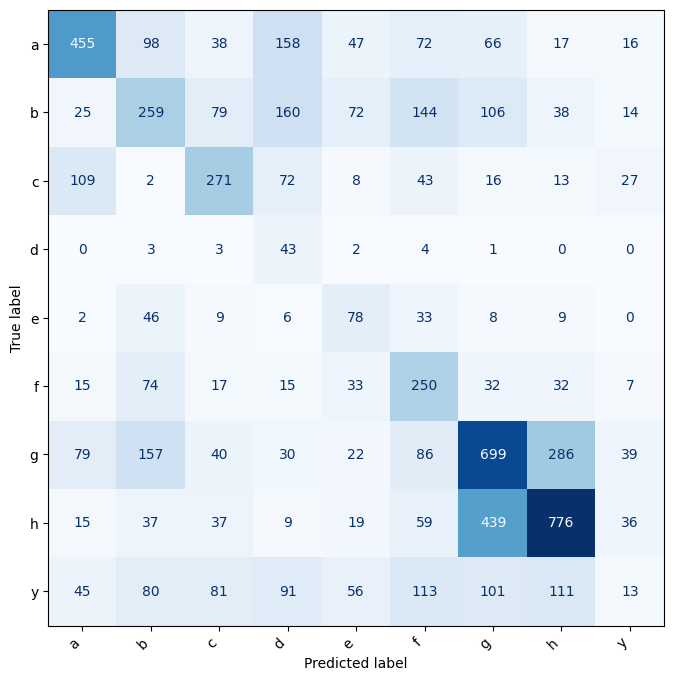

In [170]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

## Optimal Technique Application